<a href="https://colab.research.google.com/github/Maks6666/ML/blob/main/%D0%94%D0%97_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [508]:
import pandas as pd
import torch

In [509]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)


In [510]:
device

'cpu'

Дані про гриби

[посилання](https://www.kaggle.com/datasets/uciml/mushroom-classification)

In [511]:
# трохи обробки даних
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/mushrooms.csv')
df = df.drop(columns='veil-type')

encoder = OrdinalEncoder().set_output(transform='pandas')
df = encoder.fit_transform(df).astype(int)

columns = df.columns.delete(0)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

Дані непогано збалансовані

In [512]:
df['class'].value_counts()

,count
class,
0,4208
1,3916


In [513]:
df.shape

(8124, 22)

In [514]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,1.0,0.666667,0.444444,1.0,0.750,1.0,0.0,1.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
1,0,1.0,0.666667,1.000000,1.0,0.000,1.0,0.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.166667
2,0,0.0,0.666667,0.888889,1.0,0.375,1.0,0.0,0.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.375,0.4,0.500000
3,1,1.0,1.000000,0.888889,1.0,0.750,1.0,0.0,1.0,0.454545,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,1.0,0.250,0.6,0.833333
4,0,1.0,0.666667,0.333333,0.0,0.625,1.0,1.0,0.0,0.363636,...,0.666667,0.666667,0.875,0.875,0.666667,0.5,0.0,0.375,0.0,0.166667


Потрібно на основі інформації про гриб зрозуміти чи він їстівним(клас 1) `class`

In [515]:
from sklearn.model_selection import train_test_split

X = df.drop("class", axis="columns")
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [516]:
from torch.utils.data import Dataset
import torch


class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X.values).to(device)
    self.y = torch.FloatTensor(y.values).to(device)
    self.y = self.y.reshape(-1, 1)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

train_ds = MyDataset(X_train, y_train)
test_ds = MyDataset(X_test, y_test)

In [517]:
train_ds[0][0].shape

torch.Size([21])

# Завдання 2
Створіть DataLoader

In [518]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, generator=torch.Generator(device=device))
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True, generator=torch.Generator(device=device))

# Завдання 3
Створіть нейромережу

In [519]:
from torch import nn
import torch.nn.functional as F


class Block(nn.Module):
  def __init__(self, x, y):
    super().__init__()

    self.linear_1 = nn.Linear(x, y)
    self.bnorm_1 = nn.BatchNorm1d(y)
    self.linear_2 = nn.Linear(y, y-2)
    self.linear_3 = nn.Linear(y-2, y-4)
    self.linear_4 = nn.Linear(y-4, y-6)


  def forward(self, x):
    out = self.linear_1(x)
    out = self.bnorm_1(out)
    out = F.leaky_relu(out)

    out = self.linear_2(out)
    out = F.leaky_relu(out)

    out = self.linear_3(out)
    out = F.leaky_relu(out)

    out = self.linear_4(out)
    out = F.leaky_relu(out)

    return out




In [520]:
class Model(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()

    self.model = nn.Sequential(
          Block(input_dim, hidden_dim),
          Block(hidden_dim-6, hidden_dim//4),


          nn.Linear(hidden_dim//10, output_dim),
          nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

  def predict(self, X, device="cpu"):
    X_data = torch.FloatTensor(X.values).to(device)

    with torch.no_grad():
      y_pred = self.forward(X_data)


    return y_pred.cpu().numpy().squeeze()




model = Model(21, 36, 1)
model

Model(
  (model): Sequential(
    (0): Block(
      (linear_1): Linear(in_features=21, out_features=36, bias=True)
      (bnorm_1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_2): Linear(in_features=36, out_features=34, bias=True)
      (linear_3): Linear(in_features=34, out_features=32, bias=True)
      (linear_4): Linear(in_features=32, out_features=30, bias=True)
    )
    (1): Block(
      (linear_1): Linear(in_features=30, out_features=9, bias=True)
      (bnorm_1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear_2): Linear(in_features=9, out_features=7, bias=True)
      (linear_3): Linear(in_features=7, out_features=5, bias=True)
      (linear_4): Linear(in_features=5, out_features=3, bias=True)
    )
    (2): Linear(in_features=3, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [521]:
# from torch import nn
# import torch.nn.functional as F

# class Model(nn.Module):
#   def __init__(self, input_dim, hidden_dim, output_dim):
#     super().__init__()


#     self.linear_1 = nn.Linear(input_dim, hidden_dim)
#     self.linear_2 = nn.Linear(hidden_dim, hidden_dim-4)
#     self.linear_3 = nn.Linear(hidden_dim-4, hidden_dim-9)
#     self.linear_4 = nn.Linear(hidden_dim-9, hidden_dim-14)
#     self.linear_5 = nn.Linear(hidden_dim-14, hidden_dim-19)
#     self.linear_6 = nn.Linear(hidden_dim-19, hidden_dim-24)
#     self.linear_7 = nn.Linear(hidden_dim-24, hidden_dim-29)
#     self.linear_8 = nn.Linear(hidden_dim-29, output_dim)


#   def forward(self, x):
#     out = self.linear_1(x)
#     out = F.relu(out)
#     out = self.linear_2(out)
#     out = F.relu(out)
#     out = self.linear_3(out)
#     out = F.relu(out)
#     out = self.linear_4(out)
#     out = F.relu(out)
#     out = self.linear_5(out)
#     out = F.relu(out)
#     out = self.linear_6(out)
#     out = F.relu(out)
#     out = self.linear_7(out)
#     out = F.relu(out)
#     out = self.linear_8(out)
#     out = F.sigmoid(out)

#     return out


#   def predict(self, X, device="cpu"):
#     X = torch.FloatTensor(X.values).to(device)

#     with torch.no_grad():
#       y_pred = self.forward(X)

#     return y_pred.cpu().numpy().squeeze()

# model = Model(21, 31, 1)
# model

# Завдання 4
Визначте функцію втрат та оптимізатор, можливо графік швидкості навчання

In [522]:
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [523]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=500, gamma=0.1)

# Завдання 5
Натренуйте нейромережу.

In [524]:
# import time

# def train(model, optimizer, loss_fn, train_dl, val_dl,
#           metrics=None, metrics_name=None, epochs=20, device="cpu", task='binary'):


#     print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
#           (type(model).__name__, type(optimizer).__name__,
#            optimizer.param_groups[0]['lr'], epochs, device))

#     metrics = metrics if metrics else []
#     metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

#     history = {} # Collects per-epoch loss and metrics like Keras' fit().
#     history['loss'] = []
#     history['val_loss'] = []
#     for name in metrics_name:
#         history[name] = []
#         history[f'val_{name}'] = []

#     # model.to(device)

#     start_time_train = time.time()

#     for epoch in range(epochs):

#         # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
#         start_time_epoch = time.time()

#         model.train()
#         history_train = {name: 0 for name in ['loss']+metrics_name}

#         for batch in train_dl:
#             x    = batch[0].to(device)
#             y    = batch[1].to(device)
#             y_pred = model(x)
#             loss = loss_fn(y_pred, y)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             y_pred = y_pred.detach().cpu().numpy()
#             y = y.detach().cpu().numpy()


#             history_train['loss'] += loss.item() * x.size(0)
#             for name, func in zip(metrics_name, metrics):
#               try:
#                   history_train[name] += func(y, y_pred) * x.size(0)
#               except:
#                   if task == 'binary': y_pred_ = y_pred.round()
#                   elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
#                   history_train[name] += func(y, y_pred_) * x.size(0)

#         for name in history_train:
#             history_train[name] /= len(train_dl.dataset)


#         # --- EVALUATE ON VALIDATION SET -------------------------------------
#         model.eval()
#         history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

#         with torch.no_grad():
#             for batch in val_dl:
#                 x    = batch[0].to(device)
#                 y    = batch[1].to(device)
#                 y_pred = model(x)
#                 loss = loss_fn(y_pred, y)

#                 y_pred = y_pred.cpu().numpy()
#                 y = y.cpu().numpy()

#                 history_val['val_loss'] += loss.item() * x.size(0)
#                 for name, func in zip(metrics_name, metrics):
#                     try:
#                         history_val['val_'+name] += func(y, y_pred) * x.size(0)
#                     except:
#                         if task == 'binary': y_pred_ = y_pred.round()
#                         elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

#                         history_val['val_'+name] += func(y, y_pred_) * x.size(0)

#         for name in history_val:
#             history_val[name] /= len(val_dl.dataset)

#         # PRINTING RESULTS

#         end_time_epoch = time.time()

#         for name in history_train:
#             history[name].append(history_train[name])
#             history['val_'+name].append(history_val['val_'+name])

#         total_time_epoch = end_time_epoch - start_time_epoch

#         print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
#         for name in history_train:
#             print(f'{name}: {history[name][-1]:10.3g}', end='\t')
#             print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
#         print()

#     # END OF TRAINING LOOP

#     end_time_train       = time.time()
#     total_time_train     = end_time_train - start_time_train
#     print()
#     print('Time total:     %5.2f sec' % (total_time_train))

#     return history

In [525]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='binary'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = F.sigmoid(y_pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        scheduler.step()
        # optimizer.step()
        history['lr'].append(scheduler.get_last_lr())


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                y_pred = F.sigmoid(y_pred)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [526]:
train_ds[0][0].shape

torch.Size([21])

In [527]:
from sklearn.metrics import accuracy_score
history = train(model, optimizer, loss_func, train_dl, test_dl,
                epochs=200,
                metrics=[accuracy_score],
                device=device,
                task='binary')

train() called: model=Model, opt=Adam(lr=0.100000), epochs=200, device=cpu

Epoch    1    0sec	loss:       0.38	val_loss:       1.07	accuracy_score:      0.482	val_accuracy_score:      0.749	
Epoch    2    0sec	loss:      0.051	val_loss:      0.206	accuracy_score:      0.482	val_accuracy_score:       0.56	
Epoch    3    0sec	loss:     0.0353	val_loss:     0.0146	accuracy_score:      0.488	val_accuracy_score:      0.482	
Epoch    4    0sec	loss:    0.00903	val_loss:      0.111	accuracy_score:      0.482	val_accuracy_score:      0.482	
Epoch    5    0sec	loss:    0.00387	val_loss:    0.00432	accuracy_score:      0.482	val_accuracy_score:      0.482	
Epoch    6    0sec	loss:    0.00202	val_loss:   9.39e-05	accuracy_score:      0.483	val_accuracy_score:      0.491	
Epoch    7    0sec	loss:     0.0586	val_loss:      0.389	accuracy_score:      0.487	val_accuracy_score:      0.482	
Epoch    8    0sec	loss:     0.0275	val_loss:    0.00676	accuracy_score:      0.504	val_accuracy_score:      0.6

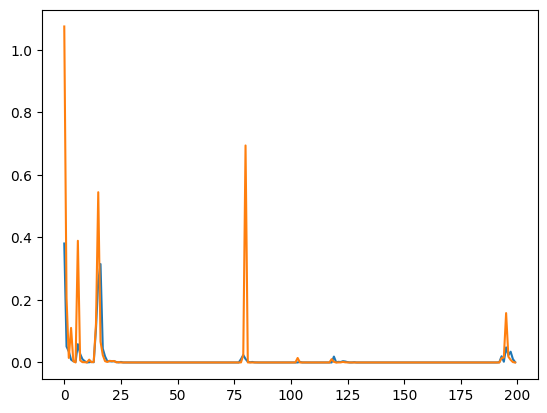

In [528]:
import matplotlib.pyplot as plt

plt.plot(history["loss"])
plt.plot(history["val_loss"])


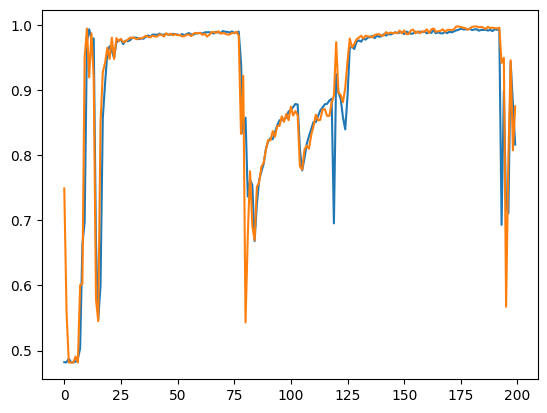

In [529]:
import matplotlib.pyplot as plt

plt.plot(history["accuracy_score"])
plt.plot(history["val_accuracy_score"])

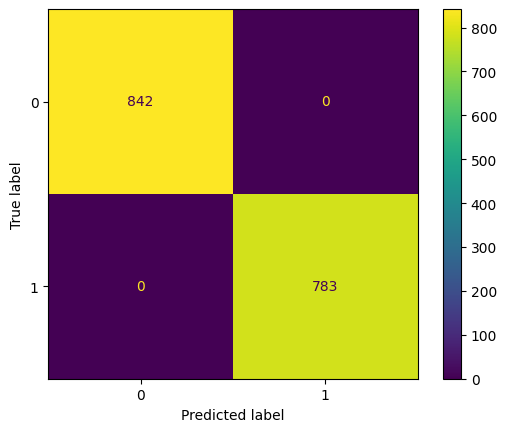

In [530]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X_test)


ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())

# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [531]:
torch.save(model, 'model.pt')

model = torch.load("/content/model.pt")
model = model.to(device)



X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)
print(y[0])

tensor([[1.0000, 0.6667, 0.4444, 1.0000, 0.7500, 1.0000, 0.0000, 1.0000, 0.3636,
         0.0000, 0.7500, 0.6667, 0.6667, 0.8750, 0.8750, 0.6667, 0.5000, 1.0000,
         0.2500, 0.6000, 0.8333]])
torch.Size([1, 21])
1


In [532]:
res = model(X_data)
with torch.no_grad():
  print(res)



tensor([[1.]], grad_fn=<SigmoidBackward0>)
